In [ ]:
# https://www.kaggle.com/code/peremartramanonellas/gan-tutorial-2-generating-color-images

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from keras.utils.vis_utils import plot_model

print (tf.__version__)

# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version

# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

2.10.0
OpenCV: 4.7.0
matplotlib: 3.6.3
graphviz: 0.20.1


In [2]:
def plot_results(images, n_cols=None, unnorm=True):
    '''visualizes fake images'''
    display.clear_output(wait=False)  

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        imageorg = image
        if unnorm:
          # imageorg = (image +1) * 0.5
          imageorg = (image * 0.5) + 0.5
        plt.imshow(imageorg)
        plt.axis("off")

In [3]:
# Specify the location of images after you have downloaded them
ImgLocation = main_dir + "/HW32_Myshkavets S.A./images"

# Create a list to store image paths
ImagePaths=[]
for image in list(os.listdir(ImgLocation)):
    if image != '.DS_Store':
        ImagePaths = ImagePaths + [ImgLocation + "/" + image]
        
# Load images and resize to 32 x 32
data_lowres=[]
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lowres = cv2.resize(image, (32, 32))
    data_lowres.append(image_lowres)
    
# Convert image data to numpy array
data_lowres = np.array(data_lowres)

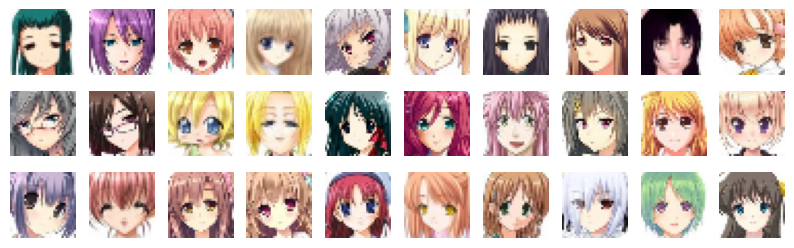

In [4]:
plot_results(data_lowres[0:30], 10, False)

In [5]:
# The GAN Hacks recommend to normalize and scale the pixals to values between -1 and 1. 
# normalize pixel values
data_lowres = data_lowres.astype(np.float32)

# Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
data_lowres = (data_lowres - 127.5) / 127.5

# Show data shape
print("Shape of data_lowres: ", data_lowres.shape)

Shape of data_lowres:  (63565, 32, 32, 3)


In [6]:
BATCH_SIZE = 128

# create batches of tensors to be fed into the model
dataset = tf.data.Dataset.from_tensor_slices(data_lowres)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-07 16:52:35.735791: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-07 16:52:35.736425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
noise_input = 100
generator = keras.models.Sequential([
    keras.layers.Dense(4 * 4 * 128, input_shape=[noise_input], 
                       activation=keras.layers.LeakyReLU(alpha=0.2)),
    
    #Start with small representations of the image of 4 x 4
    keras.layers.Reshape([4, 4, 128]),
    keras.layers.BatchNormalization(),

    #First UpSample doubling the size to 8x8
    keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),

    #Second UpSample doubling the size to 16x16
    keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),

    #Last UpSample doubling the size to 32x32
    keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="SAME",
                                 activation='tanh'),
                                 ])

In [8]:
#From noise to 32 x 32 x 3
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        262272    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                        

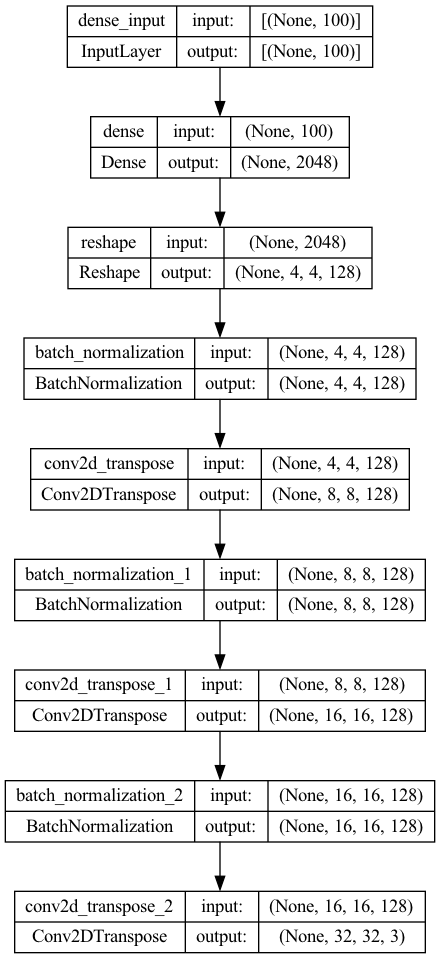

In [9]:
#From noise to 32 x 32 x 3
plot_model(generator, show_shapes=True, 
           show_layer_names=True)

shape of the generated batch: (16, 32, 32, 3)


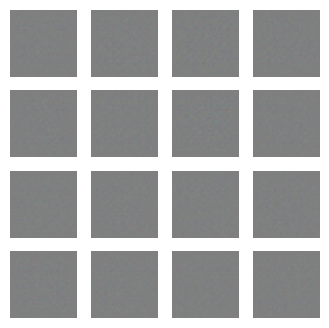

In [10]:
# generate a batch of noise input (batch size = 16)
test_noise = tf.random.normal([16, noise_input])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
plot_results(test_image, n_cols=4)

print(f'shape of the generated batch: {test_image.shape}')

In [11]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[32, 32, 3]),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 64)          0         
                                                                 
 flatten (Flatten)           (None, 1024)             

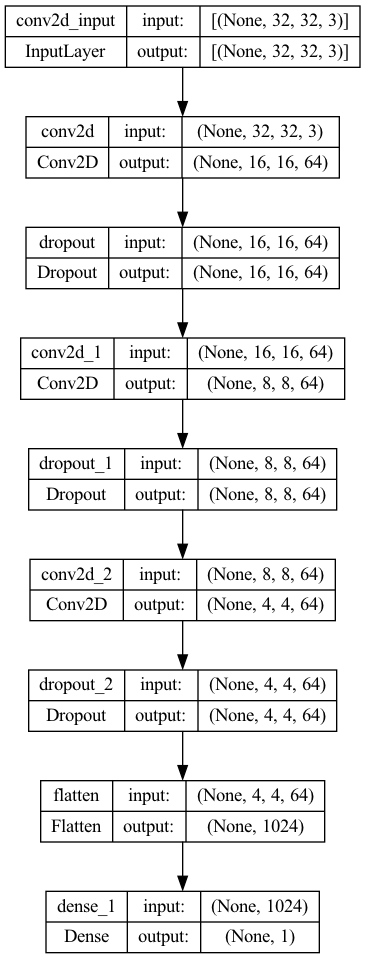

In [13]:
plot_model(discriminator, show_shapes=True, show_layer_names=True)

In [14]:
#Creating the GAN with the Generator & Discriminator models. 
gan = keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         739075    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 79745     
                                                                 
Total params: 818,820
Trainable params: 818,052
Non-trainable params: 768
_________________________________________________________________


In [15]:
#discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
optimizer_disc = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_gan = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_disc, metrics=['accuracy'])

discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer=optimizer_gan)

In [16]:
#functions to smooth the labels. Positive, and negative.
def smooth_positive(y):
  #range values 0.8 - 1.2
  return y -0.2 + (np.random.random(y.shape) * 0.4)

def smooth_negative(y):
  #range values 0 - 0.3
  return y + np.random.random(y.shape) * 0.3

In [17]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=30):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            real_images = tf.cast(real_images, tf.float32)
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # use the noise to generate fake images
            fake_images = generator(noise)

            # create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_zeros = smooth_negative(np.zeros((batch_size, 1)))
            discriminator_ones = smooth_positive(np.ones((batch_size, 1)))
            discriminator_labels= tf.convert_to_tensor(np.concatenate((discriminator_zeros, discriminator_ones)))
            #discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # ensure that the discriminator is trainable
            discriminator.trainable = True

            # use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # label all generated images to be "real"
            generator_ones = smooth_positive(np.ones((batch_size, 1)))
            generator_labels = tf.convert_to_tensor(generator_ones)
            #generator_labels = tf.constant([[1.]] * batch_size)

            # freeze the discriminator
            discriminator.trainable = False

            # train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
        
        # plot the fake images used to train the discriminator
        plot_results(fake_images[0:30], 10)                     
        plt.show()      

In [18]:
#Sample of smoothed labels
#[0:4] False
#[4:9] True
batch_size=5

#discriminator_zeros = np.zeros((batch_size, 1)) #+ np.ones(batch_size)
discriminator_zeros = smooth_negative(np.zeros((batch_size, 1)))
discriminator_ones = smooth_positive(np.ones((batch_size, 1)))
discriminator_labels= tf.convert_to_tensor(np.concatenate((discriminator_zeros, discriminator_ones)))
discriminator_labels

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[0.05098048],
       [0.25058917],
       [0.1188668 ],
       [0.10836921],
       [0.22755058],
       [1.07547145],
       [0.89476713],
       [0.81587466],
       [1.19387509],
       [0.94774942]])>

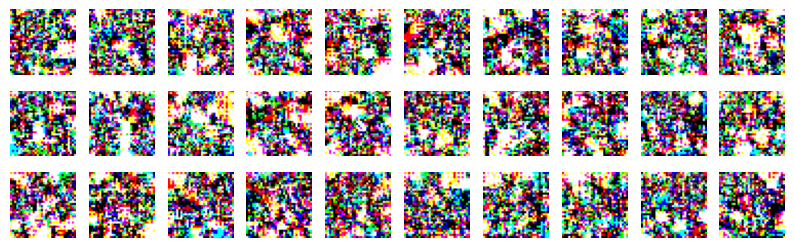

Epoch 52/100


KeyboardInterrupt: 

In [19]:
train_gan(gan, dataset, noise_input, 100)